In [71]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score

import sys, os, math
import time
import datetime

from sklearn import preprocessing
from sklearn import metrics

from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn import preprocessing

In [72]:
train = pd.read_csv('train.csv')
train.head()

,row_id,x,y,accuracy,time,place_id
0,0,0.7941,9.0809,54,470702,8523065625
1,1,5.9567,4.7968,13,186555,1757726713
2,2,8.3078,7.0407,74,322648,1137537235
3,3,7.3665,2.5165,65,704587,6567393236
4,4,4.0961,1.1307,31,472130,7440663949


In [79]:
## sample dataset 

th = 100

df_cell_train = train[(train['x']>=0)&(train['x']<1)&
                     (train['y']>=0)&(train['y']<1)] 

place_counts = df_cell_train.place_id.value_counts()
mask = (place_counts[df_cell_train.place_id.values]>=th).values
df_cell_train = df_cell_train.loc[mask]


df_cell_train["hour"] = (df_cell_train["time"]%(60*24))/60.
df_cell_train["dayofweek"] = np.ceil((df_cell_train["time"]%(60*24*7))/(60.*24))
df_cell_train['dayofmonth'] = np.ceil((df_cell_train['time']%(60*24*30))/(60.*24))
df_cell_train["dayofyear"] = np.ceil((df_cell_train["time"]%(60*24*365))/(60.*24))

df_cell_train["month"] = (df_cell_train['time']//43200)%12+1


df_cell_train.head()

,row_id,x,y,accuracy,time,place_id,hour,dayofweek,dayofmonth,dayofyear,month
149,149,0.0179,0.2321,67,541943,8050782732,8.383333,6.0,17.0,12.0,1
171,171,0.1489,0.2586,59,154764,5938943847,11.400000,3.0,18.0,108.0,4
255,255,0.3659,0.1537,176,273956,1412889338,5.933333,2.0,11.0,191.0,7
334,334,0.9536,0.3766,95,653258,7578348615,15.633333,6.0,4.0,89.0,4
386,386,0.6733,0.8339,82,673162,1273954023,11.366667,6.0,18.0,103.0,4


# place_id frequency

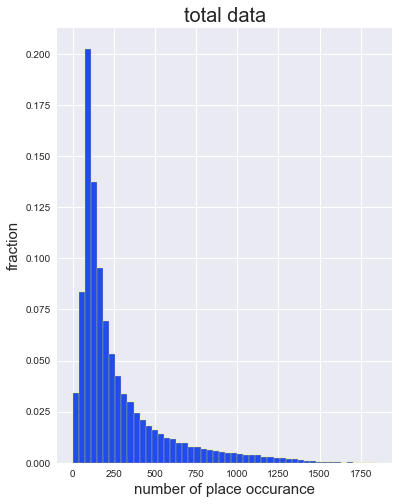

In [53]:
### whole data 

df_placecounts = train['place_id'].value_counts()

counts, bins = np.histogram(df_placecounts.values, bins = 50)
binsc = bins[:-1]+np.diff(bins)/2

plt.figure(3, figsize = (6,8))
plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0], color = '#224bed', edgecolor = '#ede923')
plt.grid(True)
plt.xlabel('number of place occurance', size = 15)
plt.ylabel('fraction', size = 15)
plt.title('total data', size = 20)
plt.show()

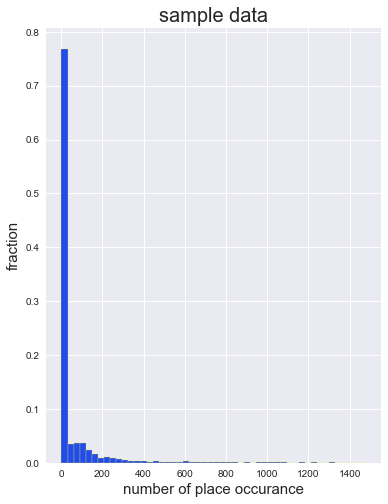

In [57]:
### sample data 

df_placecounts = df_cell_train['place_id'].value_counts()

counts, bins = np.histogram(df_placecounts.values, bins = 50)
binsc = bins[:-1]+np.diff(bins)/2

plt.figure(3, figsize = (6,8))
plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0], color = '#224bed', edgecolor = '#ede923')
plt.grid(True)
plt.xlabel('number of place occurance', size = 15)
plt.ylabel('fraction', size = 15)
plt.title('sample data', size = 20)
plt.show()

# quality

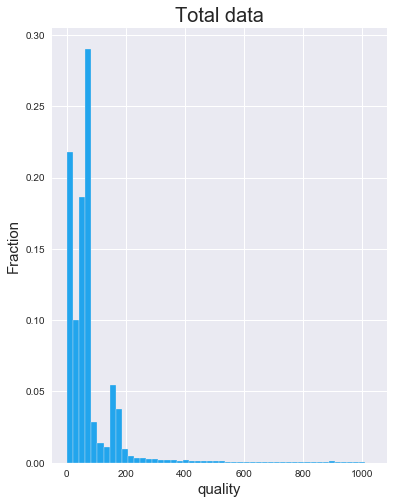

In [81]:
### check accuracy frequency

counts1, bins1 = np.histogram(train['accuracy'], bins = 50)
binsc1 = bins1[:-1]+np.diff(bins1)/2


plt.figure(figsize = (6,8))

plt.bar(binsc1, counts1/(counts1.sum()*1.0), width = np.diff(bins1)[0], color = '#22a5ed', edgecolor = '#f2eded')
#plt.grid(True)
plt.xlabel('quality', size = 15)
plt.ylabel('Fraction', size= 15)
plt.title('Total data', size = 20)

plt.show()

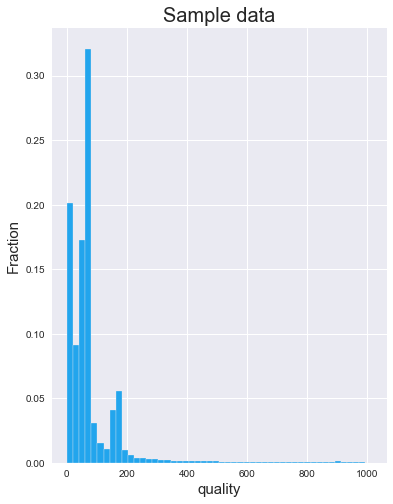

In [82]:
counts2, bins2 = np.histogram(df_cell_train['accuracy'], bins = 50)
binsc2 = bins2[:-1]+np.diff(bins2)/2


plt.figure(figsize = (6,8))

plt.bar(binsc2, counts2/(counts2.sum()*1.0), width = np.diff(bins2)[0], color = '#22a5ed', edgecolor = '#f2eded')
#plt.grid(True)
plt.xlabel('quality', size = 15)
plt.ylabel('Fraction', size= 15)
plt.title('Sample data', size = 20)

plt.show()

# Time frequency

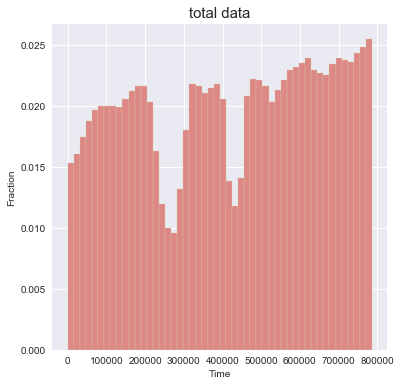

In [64]:
counts1, bins1 = np.histogram(train['time'], bins = 50)
binsc1 = bins1[:-1]+np.diff(bins1)/2

plt.figure(figsize = (6,6))

plt.bar(binsc1, counts1/(counts1.sum()*1.0), width = np.diff(bins1)[0], color = '#dd8787', edgecolor = '#d4db99')
plt.grid(True)
plt.xlabel('Time', size = 10)
plt.ylabel('Fraction', size = 10)
plt.title('total data', size = 15)

plt.show()

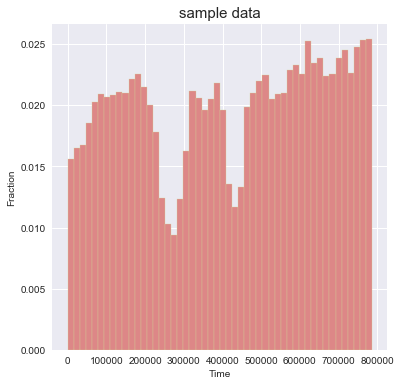

In [65]:
counts2, bins2 = np.histogram(df_cell_train['time'], bins = 50)
binsc2 = bins2[:-1]+np.diff(bins2)/2

plt.figure(figsize = (6,6))

plt.bar(binsc2, counts2/(counts2.sum()*1.0), width = np.diff(bins2)[0], color = '#dd8787', edgecolor = '#d4db99')
plt.grid(True)
plt.xlabel('Time', size = 10)
plt.ylabel('Fraction', size = 10)
plt.title('sample data', size = 15)

plt.show()

# Time distribution ( hour, week, month, year)

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


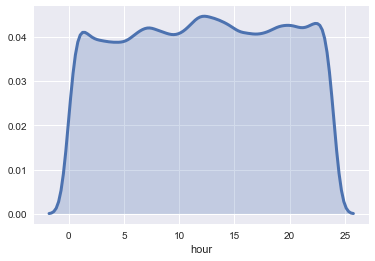

In [29]:
### hour

sns.distplot(df_cell_train['hour'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


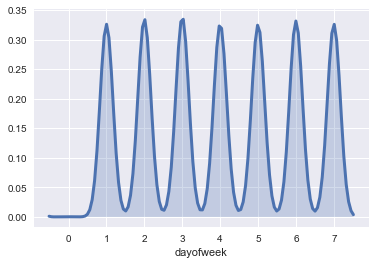

In [30]:
sns.distplot(df_cell_train['dayofweek'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


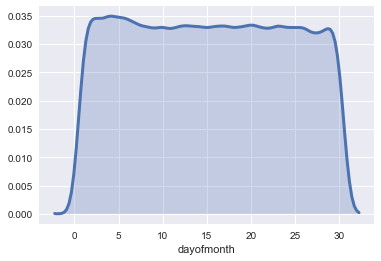

In [31]:
sns.distplot(df_cell_train['dayofmonth'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


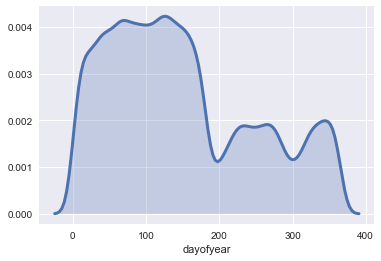

In [32]:
sns.distplot(df_cell_train['dayofyear'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

/Users/aoxu/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


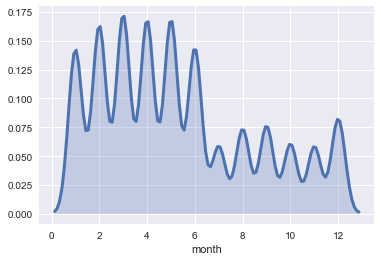

In [80]:
sns.distplot(df_cell_train['month'], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})

# top 10 place_id

In [33]:
##### get a list of the top 10 places for future reference ####

df_placecounts = df_cell_train.place_id.value_counts()
df_placecounts = df_placecounts.sort_values(ascending = False)

In [34]:
df_topplaces = df_placecounts.iloc[0:10]

l_topplaces = list(df_topplaces.index)
print(l_topplaces)

[8507124067, 7470260459, 1511873045, 3421175639, 1254758593, 7858268564, 5861856288, 7609453580, 5108647025, 8805929689]


/Users/aoxu/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


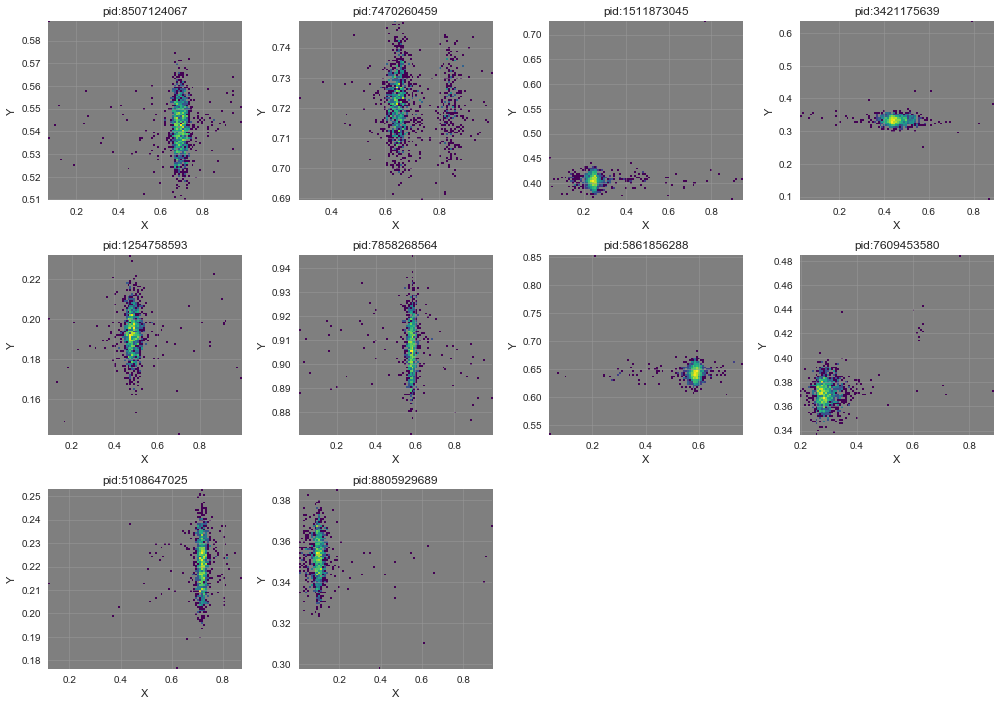

In [35]:
### check these 10 place_id`s location in (x,y) ###


plt.figure(10, figsize = (14, 16))
cmapm = plt.cm.viridis
cmapm.set_bad("0.5", 1.)

for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    df_train_place = df_cell_train[df_cell_train['place_id']==place]
    counts, binsX, binsY = np.histogram2d(df_train_place['x'], df_train_place['y'], bins=100)
    extent = [binsX.min(), binsX.max(), binsY.min(), binsY.max()]
    
    plt.subplot(5, 4, i+1)
    plt.imshow(np.log10(counts.T),
              interpolation = 'none',
              origin = 'lower',
              extent = extent,
              aspect = 'auto',
              cmap = cmapm)
    plt.grid(True, c = '0.6',lw = 0.5)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('pid:'+str(place))

plt.tight_layout()
plt.show()

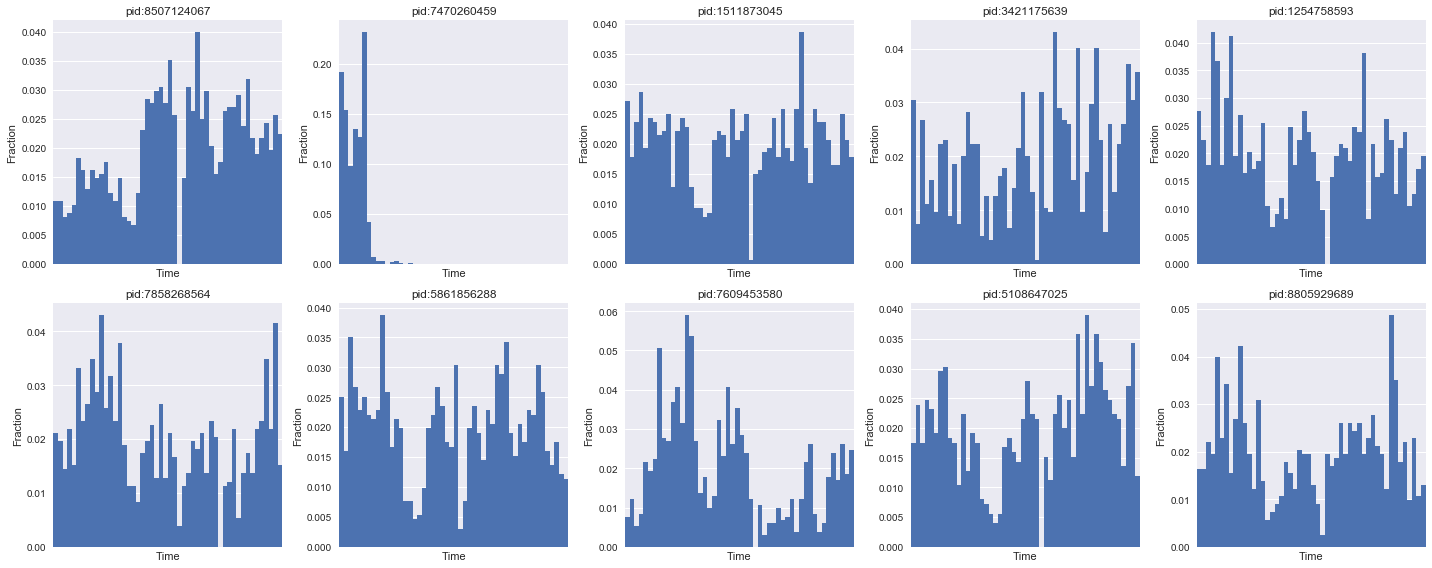

In [38]:
# check if any of the top places have time correlated visits

plt.figure(6, figsize=(20, 8))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    
    df_place = df_cell_train[df_cell_train['place_id'] == place]
    
    counts, bins = np.histogram(df_place['time'], bins = 50, range = [df_cell_train['time'].min(), df_cell_train['time'].max()])
    binsc = bins[:-1]+np.diff(bins)/2
    
    plt.subplot(2,5 , i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0])
    plt.xlim(df_cell_train['time'].min(), df_cell_train['time'].max())
    plt.grid(True)
    plt.xlabel('Time')
    plt.ylabel('Fraction')
    plt.gca().get_xaxis().set_ticks([])
    plt.title('pid:'+str(place))
    
plt.tight_layout()
plt.show()

# features correlation matrix

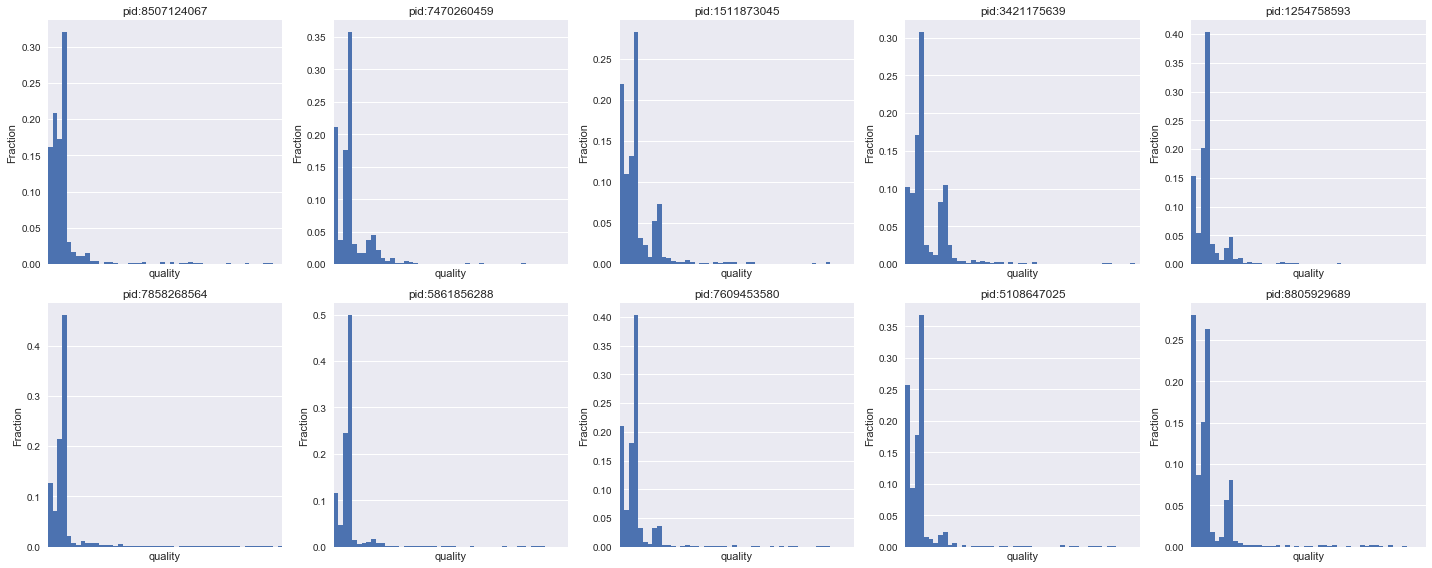

In [84]:
### check quality with top 10 place ids

plt.figure(6, figsize=(20, 8))
for i in range(len(l_topplaces)):
    place = l_topplaces[i]
    
    df_place = df_cell_train[df_cell_train['place_id'] == place]
    
    counts, bins = np.histogram(df_place['accuracy'], bins = 50, range = [df_cell_train['accuracy'].min(), df_cell_train['accuracy'].max()])
    binsc = bins[:-1]+np.diff(bins)/2
    
    plt.subplot(2,5 , i+1)
    plt.bar(binsc, counts/(counts.sum()*1.0), width = np.diff(bins)[0])
    plt.xlim(df_cell_train['accuracy'].min(), df_cell_train['accuracy'].max())
    plt.grid(True)
    plt.xlabel('quality')
    plt.ylabel('Fraction')
    plt.gca().get_xaxis().set_ticks([])
    plt.title('pid:'+str(place))
    
plt.tight_layout()
plt.show()